In [11]:
import warnings
warnings.filterwarnings("ignore")

import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import pickle
import numpy
import argparse
import os
import platform
import shutil
from tqdm import tqdm

from molzip.utils import *
from molzip.autoencoder import *

# import mdshare

In [57]:
pdb = 'pentapeptide-impl-solv.pdb'
traj = 'pentapeptide-00-500ns-impl-solv.xtc'
traj = md.load_xtc(traj, top=pdb)
traj = traj.superpose(reference=traj[0]).xyz

In [72]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt

In [80]:
def cluster_trajectory(trajectory, n_components=2, n_clusters=5, plot=True):
    """
    Perform PCA on an MD trajectory and cluster the principal components.

    Parameters:
    - trajectory: np.ndarray, shape (num_frames, num_atoms, 3)
        The input MD trajectory data.
    - n_components: int, default=2
        The number of principal components to keep.
    - n_clusters: int, default=5
        The number of clusters to form.
    - plot: boolean, default=True
        Whether to plot the PCA result with clustering.

    Returns:
    - clusters: dict
        A dictionary where keys are cluster indices and values are lists of frame numbers.
    """
    
    # Ensure the trajectory shape is correct
    num_frames, num_atoms, dim = trajectory.shape
    assert dim == 3, "The dimensions of each atom's coordinates should be 3."
    
    # Flatten the coordinates for PCA (each frame is a data point)
    X = trajectory.reshape(num_frames, num_atoms * dim)

    # Perform PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X)

    # Apply clustering (e.g., K-means)
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(principal_components)
    labels = kmeans.labels_

    # Get frame numbers for each cluster
    clusters = {}
    for frame, cluster in enumerate(labels):
        if cluster not in clusters:
            clusters[cluster] = []
        clusters[cluster].append(frame)

    # Optional: Plot the PCA result
    if plot and n_components >= 2:
        plt.subplots(figsize=(5,3.5))
        plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='viridis', alpha=0.5, s=10)
        plt.xlabel('PC 1')
        plt.ylabel('PC 2')
        plt.title('PCA of MD Trajectory with Clustering')
        plt.show()

    return clusters

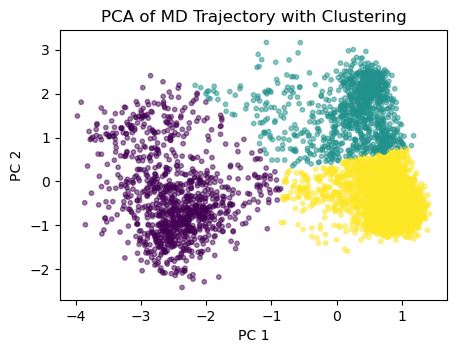

In [84]:
x = cluster_md_trajectory(trajectory=traj, n_clusters=3, n_components=2, plot=True)